# Requirements

In [57]:
import json
import pandas as pd
import numpy as np
import geopandas as gpd
from scipy.stats import pearsonr

import nltk

import sddk
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

# PLOTTING
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import geoplot as gplt

In [58]:
# setup sciencedata, google and figures exports
# (feel free to skip...)

s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")
figpath = "SDAM_data/social_diversity/socdiv_figures/"

# global parameters for plots
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../figures/" + fig_name + ".eps", format="eps")
    fig.savefig("../figures/" + fig_name + ".png")
    s.write_file(figpath + fig_name + ".eps", fig)
    s.write_file(figpath + fig_name + ".png", fig)

connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [59]:
# establish connection with gogglesheets...
file_data = s.read_file("https://sciencedata.dk/files/ServiceAccountsKey.json", "dict") # or load it from a local storage: json.load(open("../../ServiceAccountsKey.json", "r"))
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
socdiv_results = gc.open_by_url("https://docs.google.com/spreadsheets/d/1kACGBS9Xdno7FL2fPZ-vCOu4SSh9uUaZmGvnEghVs_A/edit?usp=sharing")

# Import datasets

In [60]:
LIRE = gpd.read_parquet("../data/large_data/LIRE_occupsorgs_cats.parquet")

In [61]:
def proper_nones(type_value):
    if not isinstance(type_value, str):
        type_value = None
    return type_value

LIRE["type_of_inscription_auto"] = LIRE["type_of_inscription_auto"].apply(proper_nones)

In [62]:
LIRE.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,...,37687.28,31,"[20.787767, 39.546432]",10725.84,rural,[],0,[],0,[]
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,...,23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[]
2,EDCS-28500283,"CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",50,,"['Augusti/Augustae', 'leges', 'viri']",leges,...,23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[]
3,EDCS-09400671,"CIMRM-02, 02350 = IG-12, 00274 = Andros 00124 ...",Achaia,Achaia,Andros,Andros,209,,"['litterae erasae', 'tituli sacri']",tituli sacri,...,60414.04,47,"[24.34625, 37.633122]",47547.59,rural,[],0,[],0,[]
4,EDCS-24600769,"AE 1995, 01407 = AE 2001, 01812",Achaia,Achaia,Archea Olimpia / Archaia Olympia / Olympia,"['Archea Olimpia', 'Archaia Olympia', 'Olympia']",96,,{ },{ },...,45272.69,35,"[21.435443, 37.827452]",26125.55,rural,[],0,[],0,[]


In [63]:
# mask
before235 = LIRE["not_before"] < 235
after235 = LIRE["not_before"]>=235

In [64]:
len(LIRE[before235])

114898

In [65]:
LIRE[before235]["occups_N"].sum()

4782

In [66]:
LIRE[before235]["occups_N"].sum() / LIRE["occups_N"].sum()

0.9157410953657602

In [67]:
roman_cities = gpd.read_parquet("../data/roman_cities_pop.parquet")
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson")
pleiades_regions_west = gpd.read_file("../data/pleiades_regions_west.geojson")

# Map inscriptions on cities

In [68]:
def get_my_city(row):
    context = row["urban_context_alt"]
    try:
        ID = row[context + "_city_ID"]
    except:
        ID = None
    return ID
LIRE["city_ID"] = LIRE.apply(lambda row: get_my_city(row), axis=1)

In [69]:
def get_inscriptions(ID):
    city_dict = {}
    city_data = LIRE[LIRE["city_ID"]==str(ID)]
    city_data_post235 = LIRE[(LIRE["city_ID"]==str(ID)) & (after235)]
    if len(city_data) > 0:
        # all inscriptions
        city_dict["inscr_N"] = len(city_data)
        city_dict["occups_list"] = [el for sublist in city_data["occups"] for el in sublist]
        city_dict["occups_N"] = city_data["occups_N"].sum()
        city_dict["occups_unique_N"] = len(set(city_dict["occups_list"]))
    # inscriptions pre 235
        city_dict["inscr_N_post235"] = len(city_data_post235)
        city_dict["occups_N_post235"] = city_data_post235["occups_N"].sum()
        city_dict["ratio_post235"] = len(city_data_post235) / len(city_data)
    return city_dict

cities_dict_data = roman_cities["ID"].apply(get_inscriptions)

In [70]:
cities_inscr_data = pd.DataFrame(cities_dict_data.tolist())
cities_inscr_data.head(5)

,inscr_N,occups_list,occups_N,occups_unique_N,inscr_N_post235,occups_N_post235,ratio_post235
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,[curator],1.0,1.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
roman_cities = pd.concat([roman_cities, cities_inscr_data], axis=1)

In [72]:
del cities_inscr_data
del cities_dict_data

# Explore inscriptions within cities

In [73]:
roman_cities.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,pop_est,pop_diff,western_province,inscr_N,occups_list,occups_N,occups_unique_N,inscr_N_post235,occups_N_post235,ratio_post235
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,...,1700.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,BNP; DGRG; PECS; Sear 2006.,...,1000.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,...,1000.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,...,8209.0,NaN,False,1.0,[curator],1.0,1.0,0.0,0.0,0.0
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,DGRG; Hansen and Nielsen 2004.,...,1000.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
# all cities
len(roman_cities)

1388

In [75]:
roman_cities["pop_est"].sum()

10214337.0

In [76]:
roman_cities["inscr_N"].sum()

102961.0

In [77]:
# cities with at least one inscription
(roman_cities["inscr_N"]>0).sum()

924

In [78]:
# proportion of cities with at least one inscription
(roman_cities["inscr_N"]>0).mean()

0.6657060518731989

In [79]:
# N western cities
(roman_cities["western_province"]).sum()

889

In [80]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum()

723

In [81]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum() / (roman_cities["western_province"]).sum()

0.813273340832396

In [82]:
LIRE["is_western"].sum()

125640

In [83]:
LIRE["is_western"].sum() / len(LIRE)

0.9225346941772524

# Focus on western cities alone - basic explorations (feel free to skip)

In [84]:
roman_cities = roman_cities[roman_cities["western_province"]]
len(roman_cities)

889

In [85]:
roman_cities["pop_est"].sum()

5368578.0

In [86]:
len(LIRE[(LIRE["urban_context_alt"]=="rural") & (LIRE["is_western"])])

28622

In [87]:
roman_cities["inscr_N"].sum()

96997.0

In [88]:
102489.0 + 23122

125611.0

In [89]:
roman_cities["pop_est_log"] = np.log(roman_cities["pop_est"])
roman_cities["inscr_N_log"] = np.log(roman_cities["inscr_N"])
roman_cities["occups_N_log"] = np.log(roman_cities["occups_N"])

/Users/kasev/Projects/social_diversity/socdiv_venv/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Measuring Specialization and Diversity

In [90]:
len(roman_cities)

889

In [91]:
roman_cities["inscr_N"].sum()

96997.0

In [92]:
(roman_cities["occups_N"]>0).sum()

360

In [93]:
roman_cities[roman_cities["occups_N"]>0]["inscr_N"].sum()

91757.0

In [94]:
roman_cities[roman_cities["occups_N"]>0]["inscr_N"].sum() / len(LIRE)

0.6737425655334459

In [95]:
roman_cities[roman_cities["occups_N"]>0]["pop_est"].sum()

3250628.0

In [96]:
3250628.0 / 5368578.0

0.6054914355346984

In [97]:
3250628.0 / 10214337.0

0.3182417028143873

In [98]:
97216 / len(LIRE)

0.7138262721198326

# Western cities with inscriptions (roman_cities_wo)

In [99]:
# roman cities western with at least one occupations
roman_cities_wo = roman_cities[roman_cities["occups_N"]>0].copy()

In [ ]:
roman_cities_wo["city_province"] = roman_cities_wo.apply(lambda row: row["Ancient Toponym"] + " (" + row["Province"] + ")", axis=1)

In [100]:
roman_cities_wo["occups_N"].sum()

4267.0

In [101]:
roman_cities_wo["occups_N"].sum() / LIRE["occups_N"].sum()

0.8171198774415933

In [102]:
LIRE["occups_N"].sum()

5222

In [103]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,inscr_N,occups_list,occups_N,occups_unique_N,inscr_N_post235,occups_N_post235,ratio_post235,pop_est_log,inscr_N_log,occups_N_log
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,1.0,[curator],1.0,1.0,1.0,1.0,1.000000,6.907755,0.000000,0.000000
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,7.0,"[possessor, faber]",2.0,2.0,2.0,0.0,0.285714,8.905987,1.945910,0.693147
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,409.0,"[curator, mesor, mensor, agrimensor, medicus, ...",8.0,6.0,21.0,0.0,0.051345,11.533453,6.013715,2.079442
173,Hanson2016_174,Cillium,Kasserine,Africa Proconsularis,Tunisia,3,33 C2,69,NaN,Lepelley 1979-1981; PECS; Salmon 1969; Sear 20...,...,5.0,[aerarius],1.0,1.0,2.0,0.0,0.400000,8.321908,1.609438,0.000000
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,2.0,[sartor],1.0,1.0,2.0,1.0,1.000000,6.907755,0.693147,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,120.0,[faber],1.0,1.0,13.0,0.0,0.108333,10.247432,4.787492,0.000000
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,6.0,[faber],1.0,1.0,1.0,0.0,0.166667,9.351579,1.791759,0.000000
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,29.0,"[curator, curator]",2.0,1.0,6.0,0.0,0.206897,8.521584,3.367296,0.693147
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,28.0,[forensis],1.0,1.0,0.0,0.0,0.000000,8.405367,3.332205,0.000000


In [225]:
# generate a dictionary of occupations by type
occupations_df = pd.read_csv("../data/occupations_list_hisco.csv")

def term1_plus_term2(row):
    term1_2 = row["Term"]
    if isinstance(row["Term2"], str):
        term1_2 += " " + row["Term2"]
    return term1_2

occupations_df["Term"] = occupations_df.apply(lambda row: term1_plus_term2(row), axis=1)

occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Harris_Category"]))

In [226]:
print(len(set(occups_cats_dict.values())))
set(occups_cats_dict.values())

19


{'Building',
 'Clothing',
 'Death-care sector',
 'Education',
 'Finance',
 'Food-Production',
 'Food-Retail',
 'Fuel / Raw material',
 'Glass-Working',
 'Household Goods',
 'Managerial',
 'Metal-Working',
 'Miscellaneous Services',
 'Performing Arts',
 'Plastic Arts',
 'Retail',
 'Transport',
 'Unclassified',
 'Water-Management'}

In [227]:
occups_cats_labels = list(set(occups_cats_dict.values()))
occups_cats_labels

['Metal-Working',
 'Food-Retail',
 'Finance',
 'Transport',
 'Miscellaneous Services',
 'Managerial',
 'Household Goods',
 'Clothing',
 'Plastic Arts',
 'Death-care sector',
 'Fuel / Raw material',
 'Education',
 'Performing Arts',
 'Retail',
 'Glass-Working',
 'Water-Management',
 'Food-Production',
 'Building',
 'Unclassified']

In [229]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
roman_cities_wo["occups_cats_list"] = roman_cities_wo["occups_list"].apply(cat_for_occup)

In [230]:
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Roma"]["occups_cats_list"]

991    [Unclassified, Managerial, Unclassified, Retai...
Name: occups_cats_list, dtype: object

In [231]:
roman_cities_wo["occups_cats_unique_N"] = roman_cities_wo["occups_cats_list"].apply(lambda x: len(set(x)))
roman_cities_wo["occups_cats_unique_N"]

159     1
165     2
171     3
173     1
174     1
       ..
1297    1
1311    1
1315    1
1317    1
1321    1
Name: occups_cats_unique_N, Length: 360, dtype: int64

In [232]:
len(roman_cities_wo[roman_cities_wo["occups_N"]==1])

89

In [233]:
85 / 313

0.2715654952076677

Text(0, 0.5, 'N cities')

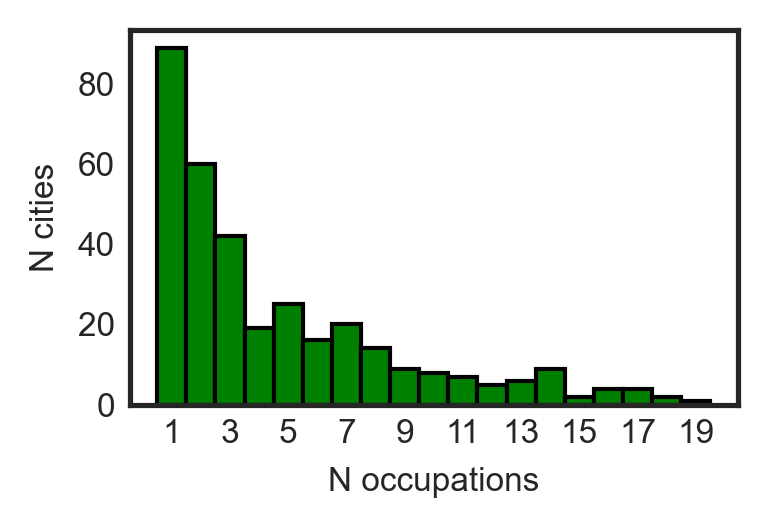

In [234]:
fig, ax = plt.subplots(figsize=(2.6, 1.8), tight_layout=True)
bins = [n+0.5 for n in range(0,20)]
roman_cities_wo["occups_N"].hist(ax=ax, edgecolor="black", color="green", bins=bins)
ax.set_xticks(range(1,20, 2))
ax.grid(False)
ax.set_xlabel("N occupations")
ax.set_ylabel("N cities")

Text(0, 0.5, 'N cities')

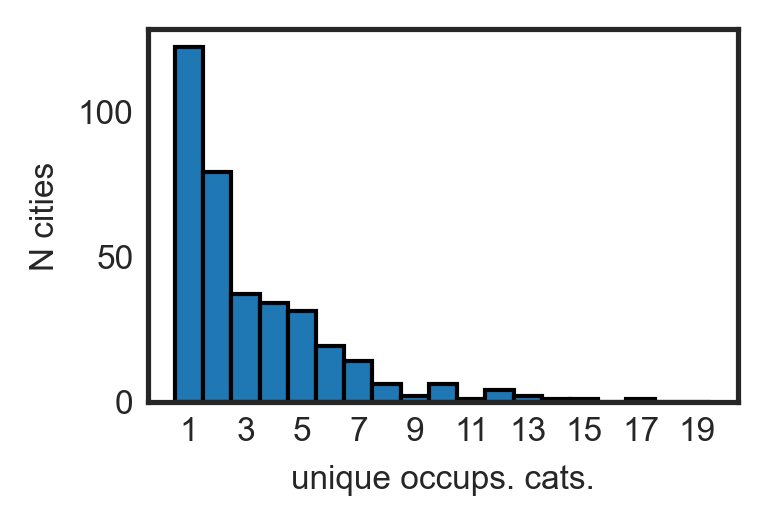

In [235]:
fig, ax = plt.subplots(figsize=(2.6, 1.8), tight_layout=True)
bins = [n+0.5 for n in range(0,20)]
roman_cities_wo["occups_cats_unique_N"].hist(ax=ax, edgecolor="black", bins=bins)
ax.set_xticks(range(1,20, 2))
ax.grid(False)
ax.set_xlabel("unique occups. cats.")
ax.set_ylabel("N cities")

In [236]:
save_figure(fig, "unique_cats_per_cities_hist")

A file with the same name ("unique_cats_per_cities_hist.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/unique_cats_per_cities_hist.eps"
A file with the same name ("unique_cats_per_cities_hist.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/unique_cats_per_cities_hist.png"


In [237]:
roman_cities_wo["occups_cats_list"]

159                                          [Managerial]
165                            [Managerial, Unclassified]
171     [Managerial, Miscellaneous Services, Miscellan...
173                                       [Metal-Working]
174                              [Miscellaneous Services]
                              ...                        
1297                                       [Unclassified]
1311                                       [Unclassified]
1315                             [Managerial, Managerial]
1317                                         [Managerial]
1321                             [Managerial, Managerial]
Name: occups_cats_list, Length: 360, dtype: object

# Specialization

In [238]:
def get_cat_row_vec(cat_list):
    cat_row_vec = []
    for cat in occups_cats_labels:
        cat_row_vec.append(cat_list.count(cat))
    return np.array(cat_row_vec)


In [239]:
roman_cities_wo["occups_cats_vec"] = roman_cities_wo["occups_cats_list"].apply(get_cat_row_vec)
roman_cities_wo["occups_cats_vec"]

159     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
165     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
171     [1, 0, 0, 0, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
173     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
174     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
1297    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1311    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1315    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1317    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1321    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: occups_cats_vec, Length: 360, dtype: object

In [240]:
def occups_cats_vec_weighted(occups_cat_vec):
    a = np.array(occups_cat_vec, dtype=float)
    a = a / sum(a)
    return a
roman_cities_wo["shares_vec"] = roman_cities_wo["occups_cats_vec"].apply(occups_cats_vec_weighted)
roman_cities_wo["shares_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, ...
171     [0.125, 0.0, 0.0, 0.0, 0.75, 0.125, 0.0, 0.0, ...
173     [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
Name: shares_vec, Length: 360, dtype: object

In [241]:
roman_cities_wo["ZI"] = roman_cities_wo["shares_vec"].apply(max)
roman_cities_wo["ZI"]

159     1.00
165     0.50
171     0.75
173     1.00
174     1.00
        ... 
1297    1.00
1311    1.00
1315    1.00
1317    1.00
1321    1.00
Name: ZI, Length: 360, dtype: float64

In [242]:
roman_cities_wo["largest_cat"] = roman_cities_wo["occups_cats_vec"].apply(max)

In [243]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw,city_province,DZI
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 10.016431924882628, ...",10.016432,Managerial,0.000000,1.000000,0.000000,Acholla (Africa Proconsularis),0.000000
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,Metal-Working,0.346574,"[5.254926108374384, 0.0, 0.0, 0.0, 0.0, 5.0082...",5.254926,Metal-Working,3.642437,2.000000,2.885390,Avitta (Africa Proconsularis),5.770780
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,Miscellaneous Services,1.559581,"[1.313731527093596, 0.0, 0.0, 0.0, 18.60610465...",18.606105,Miscellaneous Services,38.690307,1.684211,0.809934,Carthago (Africa Proconsularis),1.079912
173,Hanson2016_174,Cillium,Kasserine,Africa Proconsularis,Tunisia,3,33 C2,69,NaN,Lepelley 1979-1981; PECS; Salmon 1969; Sear 20...,...,Metal-Working,0.000000,"[10.509852216748769, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.509852,Metal-Working,0.000000,1.000000,0.000000,Cillium (Africa Proconsularis),0.000000
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,Miscellaneous Services,0.000000,"[0.0, 0.0, 0.0, 0.0, 24.808139534883722, 0.0, ...",24.808140,Miscellaneous Services,0.000000,1.000000,0.000000,Clupea (Africa Proconsularis),0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,Metal-Working,0.000000,"[10.509852216748769, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.509852,Metal-Working,0.000000,1.000000,0.000000,Catania (Sicilia),0.000000
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,Metal-Working,0.000000,"[10.509852216748769, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.509852,Metal-Working,0.000000,1.000000,0.000000,Messana (Sicilia),0.000000
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,Managerial,0.693147,"[0.0, 0.0, 0.0, 0.0, 0.0, 10.016431924882628, ...",10.016432,Managerial,6.942862,1.000000,1.442695,Panormus (Sicilia),1.442695
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 10.016431924882628, ...",10.016432,Managerial,0.000000,1.000000,0.000000,Segesta (Sicilia),0.000000


In [244]:
roman_cities_wo["ZI_cat"] = roman_cities_wo["shares_vec"].apply(lambda x: occups_cats_labels[np.argmax(x)])

In [245]:
roman_cities_wo.sort_values("ZI", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N","occups_cats_vec", "ZI", "ZI_cat"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,ZI,ZI_cat
159,Acholla,1.0,1.0,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,Managerial
840,Sipontum,10.0,1.0,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,Miscellaneous Services
797,Signia,32.0,2.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,Building
807,Trebula Balliensis,30.0,2.0,1,"[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,Managerial
813,Vitellia,13.0,2.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...",1.000000,Education
...,...,...,...,...,...,...,...
1271,Mursa,105.0,6.0,6,"[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",0.166667,Miscellaneous Services
1045,Ateste,115.0,6.0,6,"[1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.166667,Metal-Working
335,Corduba,488.0,30.0,10,"[4, 0, 0, 0, 5, 2, 0, 4, 3, 0, 0, 0, 1, 4, 0, ...",0.166667,Miscellaneous Services
789,Pompeii,3228.0,55.0,12,"[2, 0, 2, 1, 9, 9, 0, 3, 2, 0, 0, 0, 9, 7, 0, ...",0.163636,Miscellaneous Services


In [246]:
roman_cities_wo["ZIw"] = roman_cities_wo.apply(lambda row: row["ZI"] * row["occups_N_log"], axis=1)
roman_cities_wo.sort_values("ZIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_list","occups_cats_unique_N", "occups_cats_vec", "ZI", "ZIw", "ZI_cat"]]

,Ancient Toponym,inscr_N,occups_N,occups_list,occups_cats_unique_N,occups_cats_vec,ZI,ZIw,ZI_cat
901,Tibur,235.0,52.0,"[faber, curator, curator, curator, curator, cu...",10,"[3, 0, 0, 1, 1, 31, 0, 1, 0, 0, 0, 5, 1, 2, 0,...",0.596154,2.355549,Managerial
873,Alba Fucentia,81.0,11.0,"[curator, curator, curator, faber tignuarius, ...",2,"[0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.909091,2.179905,Managerial
808,Tusculum,118.0,18.0,"[curator, curator, curator, curator, curator, ...",5,"[1, 0, 0, 0, 2, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.722222,2.087491,Managerial
332,Carmo,8.0,8.0,"[agrimensor, agrimensor, agrimensor, agrimenso...",1,"[0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,2.079442,Miscellaneous Services
1287,Augusta Vindelicum,200.0,10.0,"[negotiator, negotiator, vestiarius, negotiato...",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, ...",0.900000,2.072327,Retail
...,...,...,...,...,...,...,...,...,...
690,Caesaraugusta,18.0,1.0,[horrearius],1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Managerial
689,Bracara,23.0,1.0,[fullo],1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Clothing
685,Baetulo,34.0,1.0,[curator],1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Managerial
649,Mauves,4.0,1.0,[nauta],1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Transport


In [247]:
roman_cities_wo["ZIw"] = roman_cities_wo.apply(lambda row: row["ZI"] * row["occups_N_log"], axis=1)
roman_cities_wo.sort_values("ZIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_list","occups_cats_unique_N", "occups_cats_vec", "ZI", "ZIw", "ZI_cat"]]

,Ancient Toponym,inscr_N,occups_N,occups_list,occups_cats_unique_N,occups_cats_vec,ZI,ZIw,ZI_cat
901,Tibur,235.0,52.0,"[faber, curator, curator, curator, curator, cu...",10,"[3, 0, 0, 1, 1, 31, 0, 1, 0, 0, 0, 5, 1, 2, 0,...",0.596154,2.355549,Managerial
873,Alba Fucentia,81.0,11.0,"[curator, curator, curator, faber tignuarius, ...",2,"[0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.909091,2.179905,Managerial
808,Tusculum,118.0,18.0,"[curator, curator, curator, curator, curator, ...",5,"[1, 0, 0, 0, 2, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.722222,2.087491,Managerial
332,Carmo,8.0,8.0,"[agrimensor, agrimensor, agrimensor, agrimenso...",1,"[0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,2.079442,Miscellaneous Services
1287,Augusta Vindelicum,200.0,10.0,"[negotiator, negotiator, vestiarius, negotiato...",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, ...",0.900000,2.072327,Retail
...,...,...,...,...,...,...,...,...,...
690,Caesaraugusta,18.0,1.0,[horrearius],1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Managerial
689,Bracara,23.0,1.0,[fullo],1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Clothing
685,Baetulo,34.0,1.0,[curator],1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Managerial
649,Mauves,4.0,1.0,[nauta],1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Transport


In [248]:
# Total shares
all_occups_N = roman_cities_wo["occups_N"].sum()
index_label_sum_dict = {}
for i, cat in zip(range(len(occups_cats_labels)), occups_cats_labels):
    cat_sum = sum(roman_cities_wo["occups_cats_vec"].apply(lambda vec: vec[i]))
    cat_share = cat_sum / all_occups_N
    index_label_sum_dict[i] = [cat, cat_sum, cat_share]
index_label_sum_dict

{0: ['Metal-Working', 389, 0.09116475275369111],
 1: ['Food-Retail', 44, 0.010311694398875087],
 2: ['Finance', 61, 0.014295758143895007],
 3: ['Transport', 129, 0.03023201312397469],
 4: ['Miscellaneous Services', 592, 0.13873916100304665],
 5: ['Managerial', 1006, 0.23576283102882586],
 6: ['Household Goods', 36, 0.00843684087180689],
 7: ['Clothing', 277, 0.06491680337473635],
 8: ['Plastic Arts', 52, 0.012186547925943286],
 9: ['Death-care sector', 0, 0.0],
 10: ['Fuel / Raw material', 1, 0.00023435669088352472],
 11: ['Education', 208, 0.048746191703773145],
 12: ['Performing Arts', 156, 0.03655964377782986],
 13: ['Retail', 395, 0.09257089289899227],
 14: ['Glass-Working', 8, 0.0018748535270681978],
 15: ['Water-Management', 13, 0.0030466369814858216],
 16: ['Food-Production', 204, 0.04780876494023904],
 17: ['Building', 276, 0.06468244668385283],
 18: ['Unclassified', 420, 0.09842981017108038]}

In [249]:
total_shares = np.array([val[2] for val in index_label_sum_dict.values()])
total_shares

array([9.11647528e-02, 1.03116944e-02, 1.42957581e-02, 3.02320131e-02,
       1.38739161e-01, 2.35762831e-01, 8.43684087e-03, 6.49168034e-02,
       1.21865479e-02, 0.00000000e+00, 2.34356691e-04, 4.87461917e-02,
       3.65596438e-02, 9.25708929e-02, 1.87485353e-03, 3.04663698e-03,
       4.78087649e-02, 6.46824467e-02, 9.84298102e-02])

In [250]:
def get_shares_weighted(vec):
    a = np.array(vec, dtype=float)
    b = total_shares
    shares_weighted =  np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    return shares_weighted

roman_cities_wo["shares_weighted_vec"] = roman_cities_wo["shares_vec"].apply(lambda vec: get_shares_weighted(vec))
roman_cities_wo["shares_weighted_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....
165     [0.0, 0.0, 0.0, 0.0, 0.0, 2.120775347912525, 0...
171     [1.3711439588688947, 0.0, 0.0, 0.0, 5.40582770...
173     [10.969151670951158, 0.0, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 7.20777027027027, 0.0, 0....
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....
Name: shares_weighted_vec, Length: 360, dtype: object

In [251]:
roman_cities_wo["RZI"] = roman_cities_wo["shares_weighted_vec"].apply(max)
roman_cities_wo["RZI"]

159      4.241551
165      5.079762
171      5.405828
173     10.969152
174      7.207770
          ...    
1297    10.159524
1311    10.159524
1315     4.241551
1317     4.241551
1321     4.241551
Name: RZI, Length: 360, dtype: float64

In [252]:
roman_cities_wo["RZI_cat"] = roman_cities_wo["shares_weighted_vec"].apply(lambda x: index_label_sum_dict[np.argmax(x)][0])
roman_cities_wo["RZI_cat"]

159                 Managerial
165               Unclassified
171     Miscellaneous Services
173              Metal-Working
174     Miscellaneous Services
                 ...          
1297              Unclassified
1311              Unclassified
1315                Managerial
1317                Managerial
1321                Managerial
Name: RZI_cat, Length: 360, dtype: object

In [253]:
roman_cities_wo["RZIw"] = roman_cities_wo.apply(lambda row: row["RZI"] * row["occups_N_log"], axis=1)
roman_cities_wo.sort_values("RZIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N", "occups_cats_vec", "ZI", "ZIw", "RZI_cat", "RZI", "RZIw"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,ZI,ZIw,RZI_cat,RZI,RZIw
760,Castrimoenium,135.0,16.0,7,"[0, 0, 1, 0, 0, 7, 0, 1, 0, 0, 1, 0, 3, 0, 0, ...",0.437500,1.213008,Fuel / Raw material,266.687500,739.414755
750,Atella,24.0,5.0,3,"[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...",0.600000,0.965663,Glass-Working,106.675000,171.686789
1276,Carnuntum (1),1103.0,19.0,10,"[4, 0, 0, 0, 4, 2, 0, 2, 1, 0, 0, 1, 0, 2, 1, ...",0.210526,0.619882,Glass-Working,28.072368,82.657376
1277,Carnuntum (2),314.0,9.0,7,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, ...",0.222222,0.488272,Water-Management,36.470085,80.132968
663,Andematunum,295.0,11.0,7,"[1, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, ...",0.272727,0.653971,Food-Retail,26.448347,63.420367
...,...,...,...,...,...,...,...,...,...,...
690,Caesaraugusta,18.0,1.0,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Managerial,4.241551,0.000000
689,Bracara,23.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Clothing,15.404332,0.000000
685,Baetulo,34.0,1.0,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Managerial,4.241551,0.000000
649,Mauves,4.0,1.0,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Transport,33.077519,0.000000


# Diversity

In [254]:
# again, the starting point are the shares:
roman_cities_wo["shares_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, ...
171     [0.125, 0.0, 0.0, 0.0, 0.75, 0.125, 0.0, 0.0, ...
173     [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
Name: shares_vec, Length: 360, dtype: object

In [255]:
def get_di(shares_vec):
    a = np.array(shares_vec)
    a = a**2
    hh = sum(a) # Hirschman-Herfindahl index
    ihh = 1 / hh # inverse Hirschman-Herfindahl index
    return ihh
roman_cities_wo["DI"] = roman_cities_wo["shares_vec"].apply(get_di)

In [256]:
roman_cities_wo.sort_values("DI", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N", "occups_cats_vec", "DI"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,DI
757,Capua,861.0,46.0,13,"[8, 1, 2, 1, 6, 6, 1, 4, 0, 0, 0, 2, 0, 4, 0, ...",9.446429
335,Corduba,488.0,30.0,10,"[4, 0, 0, 0, 5, 2, 0, 4, 3, 0, 0, 0, 1, 4, 0, ...",8.490566
789,Pompeii,3228.0,55.0,12,"[2, 0, 2, 1, 9, 9, 0, 3, 2, 0, 0, 0, 9, 7, 0, ...",8.473389
672,Mogontiacum,2924.0,48.0,13,"[1, 0, 4, 3, 7, 8, 1, 3, 0, 0, 0, 1, 2, 10, 0,...",8.287770
787,Ostia,2328.0,245.0,14,"[29, 5, 2, 45, 21, 44, 5, 5, 0, 0, 0, 12, 2, 2...",8.110390
...,...,...,...,...,...,...
786,Nuceria Alfaterna,68.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
796,Setia,11.0,1.0,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
797,Signia,32.0,2.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
807,Trebula Balliensis,30.0,2.0,1,"[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000


In [257]:
def get_diw(a,b):
    if b==0:
        return 0
    else:
        return a / b
roman_cities_wo["DIw"] = roman_cities_wo.apply(lambda row: get_diw(row["DI"], row['occups_N_log']), axis=1)
roman_cities_wo.sort_values("DIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_list", "occups_cats_unique_N", "DI", "DIw"]]

,Ancient Toponym,inscr_N,occups_N,occups_list,occups_cats_unique_N,DI,DIw
951,Spoletium,141.0,7.0,"[arcarius, curator, scamillarius, faber, iumen...",7,7.000000,3.597288
1045,Ateste,115.0,6.0,"[navalis, aerarius, curator, medicus, pectinat...",6,6.000000,3.348664
1271,Mursa,105.0,6.0,"[conditor, vexillarius, scriptor, negotiator, ...",6,6.000000,3.348664
986,Pisae,40.0,13.0,"[negotians, vinarius, curator, candidator, sca...",10,8.047619,3.137535
1283,Siscia,112.0,5.0,"[ferrarius, scriba, centonarius, medicus, dend...",5,5.000000,3.106675
...,...,...,...,...,...,...,...
690,Caesaraugusta,18.0,1.0,[horrearius],1,1.000000,0.000000
689,Bracara,23.0,1.0,[fullo],1,1.000000,0.000000
685,Baetulo,34.0,1.0,[curator],1,1.000000,0.000000
649,Mauves,4.0,1.0,[nauta],1,1.000000,0.000000


# Overview tables

In [301]:
all_measures = [["ZIw", "ZI_cat"], ["RZIw", "RZI_cat"], ["DI"], ["DIw"]]
sel_cols = ["Ancient Toponym", "Country", "pop_est", "inscr_N", "occups_N", "largest_cat", "occups_cats_unique_N"]

In [302]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw,city_province,DZI
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....",4.241551,Managerial,0.000000,1.000000,0.000000,Acholla (Africa Proconsularis),0.000000
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,Managerial,0.346574,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.120775347912525, 0...",5.079762,Unclassified,3.521023,2.000000,2.885390,Avitta (Africa Proconsularis),5.770780
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,Miscellaneous Services,1.559581,"[1.3711439588688947, 0.0, 0.0, 0.0, 5.40582770...",5.405828,Miscellaneous Services,11.241103,1.684211,0.809934,Carthago (Africa Proconsularis),1.079912
173,Hanson2016_174,Cillium,Kasserine,Africa Proconsularis,Tunisia,3,33 C2,69,NaN,Lepelley 1979-1981; PECS; Salmon 1969; Sear 20...,...,Metal-Working,0.000000,"[10.969151670951158, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.969152,Metal-Working,0.000000,1.000000,0.000000,Cillium (Africa Proconsularis),0.000000
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,Miscellaneous Services,0.000000,"[0.0, 0.0, 0.0, 0.0, 7.20777027027027, 0.0, 0....",7.207770,Miscellaneous Services,0.000000,1.000000,0.000000,Clupea (Africa Proconsularis),0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,Unclassified,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.159524,Unclassified,0.000000,1.000000,0.000000,Catania (Sicilia),0.000000
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,Unclassified,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.159524,Unclassified,0.000000,1.000000,0.000000,Messana (Sicilia),0.000000
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,Managerial,0.693147,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....",4.241551,Managerial,2.940019,1.000000,1.442695,Panormus (Sicilia),1.442695
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....",4.241551,Managerial,0.000000,1.000000,0.000000,Segesta (Sicilia),0.000000


In [303]:
cols_renaming = {"Ancient Toponym" : "city",
                 "Country" : "country",
                 "pop_est" : "pop. est.",
                 "inscr_N" : "N inscriptions",
                 "occups_N" : "N occupations",
                 "occups_cats_unique_N": "N sectors",
                 "ZI_cat" : "largest sector",
                 "RZI_cat" : "largest sector",
                 "largest_cat" : "N occ. in largest sector"
                 }

In [304]:
def get_sorted_table(df, sel_cols, measures):
    df = df[sel_cols + measures]
    df_sorted = df.sort_values(measures[0], ascending=False)
    for col in ["inscr_N", "pop_est", "occups_N", "occups_cats_unique_N"]:
        df_sorted[col] = df_sorted[col].astype(int)
    for val_col in ["ZIw", "RZIw", "DI", "DIw"]:
        try:
            df_sorted[val_col] = df_sorted[val_col].round(2)
        except:
            pass
    df_sorted = df_sorted.rename(columns=cols_renaming)
    return df_sorted.head(10) # .append(df_sorted.tail(3))

In [305]:
sorted_dfs = {}
for measure_cols in all_measures:
    sorted_dfs["sorted_by_" + measure_cols[0]] = get_sorted_table(roman_cities_wo, sel_cols, measure_cols)

In [306]:
sorted_dfs["sorted_by_ZIw"]

,city,country,pop. est.,N inscriptions,N occupations,N occ. in largest sector,N sectors,ZIw,largest sector
901,Tibur,Italy,6767,235,52,31,10,2.36,Managerial
873,Alba Fucentia,Italy,4471,81,11,10,2,2.18,Managerial
808,Tusculum,Italy,2138,118,18,13,5,2.09,Managerial
332,Carmo,Spain,7172,8,8,8,1,2.08,Miscellaneous Services
1287,Augusta Vindelicum,Germany,10608,200,10,9,2,2.07,Retail
779,Lavinium,Italy,3762,44,13,10,2,1.97,Managerial
991,Roma,Italy,923313,37765,1669,402,17,1.79,Managerial
781,Minturnae,Italy,4471,103,9,7,3,1.71,Managerial
402,Petuaria,United Kingdom,1000,7,5,5,1,1.61,Metal-Working
759,Casinum,Italy,1000,100,16,9,6,1.56,Managerial


In [308]:
# export to gsheets
set_with_dataframe(socdiv_results.add_worksheet("sorted_by_ZIw_10_jan31", 1,1), sorted_dfs["sorted_by_ZIw"])

In [309]:
# save to csv
sorted_dfs["sorted_by_ZIw"].to_csv("../data/sorted_by_ZIw_10.csv", index=None)

In [310]:
### latex version...

In [311]:
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Carmo"]

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw,city_province,DZI
332,Hanson2016_333,Carmo,Carmona,Baetica,Spain,3,26 E4,-50,NaN,BNP; Carreras Monfort 1995-1996; Keay 1998; Ne...,...,Miscellaneous Services,2.079442,"[0.0, 0.0, 0.0, 0.0, 7.20777027027027, 0.0, 0....",7.20777,Miscellaneous Services,14.988137,1.0,0.480898,Carmo (Baetica),0.480898


In [312]:
LIRE[(LIRE["city_ID"]=="333") & (LIRE["occups_N"]>0)]

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats,city_ID
58538,EDCS-22400457,"CIL 02, *00128 = CILA-02-04, *00031 = HEp 1999...",Baetica,Baetica,Carmona / Carmo,"['Carmona', 'Carmo']",117,,{ },{ },...,331,"[-5.671334, 37.614155]",16016.78,medium,"[agrimensor, agrimensor, agrimensor, agrimenso...",8,"[collegium, collegium, collegium, collegium, c...",9,"[Professional, technical and related workers, ...",333


In [313]:
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Augusta Vindelicum"]

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw,city_province,DZI
1287,Hanson2016_1288,Augusta Vindelicum,Augsburg,Raetia,Germany,2,12 D4,-15,NaN,BNP; Boatwright 2000; McEvedy 2011; PECS; Quin...,...,Retail,2.072327,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9.722278,Retail,22.386374,1.219512,0.529627,Augusta Vindelicum (Raetia),0.588475


In [314]:
LIRE[(LIRE["city_ID"]=="1288") & (LIRE["occups_N"]>0)]

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats,city_ID
45003,EDCS-27100317,"CIL 03, 05800 (p 1853) = D 07108 = IBR 00111",Raetia,Raetia,Augsburg / Augusta Vindelicorum,"['Augsburg', 'Augusta Vindelicorum']",300,,"['officium/professio', 'ordo decurionum', 'ord...",tituli operum,...,1287,"[10.909768, 47.909884]",50673.56,medium,[negotiator],1,[],0,[Sales workers],1288
45019,EDCS-27100333,"CIL 03, 05816 = IBR 00127",Raetia,Raetia,Augsburg / Augusta Vindelicorum,"['Augsburg', 'Augusta Vindelicorum']",300,,"['milites', 'officium/professio', 'tituli sepu...",tituli sepulcrales,...,1287,"[10.909768, 47.909884]",51368.73,medium,"[negotiator, vestiarius]",2,[],0,"[Sales workers, Sales workers]",1288
45027,EDCS-27200188,"CIL 03, 05824 = D 07598 = IBR 00135",Raetia,Raetia,Augsburg / Augusta Vindelicorum,"['Augsburg', 'Augusta Vindelicorum']",300,,"['mulieres', 'officium/professio', 'seviri Aug...",tituli sepulcrales,...,1287,"[10.909768, 47.909884]",50255.03,medium,[negotiator artis purpurariae],1,[],0,[],1288
45033,EDCS-27200194,"CIL 03, 05830 = IBR 00141 (p V) = CSIR-D-01-01...",Raetia,Raetia,Augsburg / Augusta Vindelicorum,"['Augsburg', 'Augusta Vindelicorum']",300,,"['officium/professio', 'tituli sepulcrales', '...",tituli sepulcrales,...,1287,"[10.909768, 47.909884]",50989.15,medium,[negotiator],1,[],0,[Sales workers],1288
45036,EDCS-27200197,"CIL 03, 05833 = IBR 00144",Raetia,Raetia,Augsburg / Augusta Vindelicorum,"['Augsburg', 'Augusta Vindelicorum']",300,,"['mulieres', 'officium/professio', 'tituli sep...",tituli sepulcrales,...,1287,"[10.909768, 47.909884]",50255.03,medium,"[negotiator, cretaria]",2,[],0,"[Sales workers, Sales workers]",1288
45070,EDCS-37600014,"IBR 00175,1 (p V)",Raetia,Raetia,Augsburg / Augusta Vindelicorum,"['Augsburg', 'Augusta Vindelicorum']",300,,"['mulieres', 'tituli sepulcrales', 'tria nomin...",tituli sepulcrales,...,1287,"[10.909768, 47.909884]",51229.86,medium,[lanius],1,[],0,"[Production and related workers, transport equ...",1288
45089,EDCS-31001577,"Wagner-02, 00025",Raetia,Raetia,Augsburg / Augusta Vindelicorum,"['Augsburg', 'Augusta Vindelicorum']",300,,"['officium/professio', 'tituli operum', 'titul...","['tituli operum', 'tituli sacri']",...,1287,"[10.909768, 47.909884]",51417.45,medium,[negotiator],1,[],0,[Sales workers],1288
45470,EDCS-73200092,"AJahrBay-2014-70 = AE 2015, 01031",Raetia,Raetia,Oberhausen / Augsburg-Oberhausen / Augusta Vin...,"['Oberhausen', 'Augsburg-Oberhausen', 'Augusta...",200,,"['milites', 'mulieres', 'officium/professio', ...",tituli sepulcrales,...,1287,"[10.909768, 47.909884]",52798.31,medium,[negotiator artis vestiariae],1,[],0,[],1288


In [316]:
set_with_dataframe(socdiv_results.add_worksheet("augusta_vindelicum_jan31", 1, 1), LIRE[(LIRE["city_ID"]=="1288") & (LIRE["occups_N"]>0)])

In [317]:
# Augusta Vindelicum ZIw score before correction
9/10 * np.log(10)

2.0723265836946414

In [318]:
# Augusta Vindelicum ZIw score after correction
(8/9) * np.log(9)

1.9530885131877507

In [319]:
##
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Alba Fucentia"]

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw,city_province,DZI
873,Hanson2016_874,Alba Fucentia,Albe,Italia (IV Samnium),Italy,3,42 E4,-303,NaN,Beloch 1880; Beloch 1886; Bispham 2007; Cornel...,...,Managerial,2.179905,"[0.0, 0.0, 0.0, 0.0, 0.0, 3.8559551780227723, ...",3.855955,Managerial,9.246177,1.19802,0.499613,Alba Fucentia (Italia (IV Samnium)),0.549574


In [320]:
LIRE[(LIRE["city_ID"]=="874") & (LIRE["occups_N"]>0)]

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats,city_ID
47651,EDCS-08400219,"Avezzano 00076 = StudRom-1982-367 = AE 1984, 0...",Samnium / Regio IV,Samnium / Regio IV,Albe / Alba Fucens,"['Albe', 'Alba Fucens']",200,,"['ordo decurionum', 'tituli sepulcrales', 'tri...",tituli sepulcrales,...,874,"[13.408983, 42.079894]",364.97,small,[curator],1,[],0,[Administrative and managerial workers],874
123458,EDCS-14804952,"CIL 09, 03922 = Avezzano 00028 = AE 2006, +00383",Samnium / Regio IV,Samnium / Regio IV,Albe / Alba Fucens,"['Albe', 'Alba Fucens']",161,,"['Augusti/Augustae', 'liberti/libertae', 'mili...","['tituli operum', 'tituli sacri', 'tituli sepu...",...,874,"[13.408983, 42.079894]",106.93,small,"[curator, curator]",2,[],0,"[Administrative and managerial workers, Admini...",874
123459,EDCS-14804953,"CIL 09, 03923 = D 06536 = Questori 00255",Samnium / Regio IV,Samnium / Regio IV,Albe / Alba Fucens,"['Albe', 'Alba Fucens']",149,,"['milites', 'officium/professio', 'ordo decuri...","['tituli sacri', 'tituli sepulcrales']",...,874,"[13.408983, 42.079894]",106.93,small,"[faber tignuarius, curator, curator, curator, ...",6,[collegium],1,[],874
123461,EDCS-14804980,"CIL 09, 03950 (p 682) = CIL 06, 00859 (p 3007)...",Samnium / Regio IV,Samnium / Regio IV,Albe / Alba Fucens,"['Albe', 'Alba Fucens']",168,,"['mulieres', 'ordo decurionum', 'sacerdotes pa...","['tituli honorarii', 'tituli sacri']",...,874,"[13.408983, 42.079894]",106.93,small,[curator],1,[],0,[Administrative and managerial workers],874
123477,EDCS-60400052,"Spigolature-07, 00006 = AE 2013, 00398",Samnium / Regio IV,Samnium / Regio IV,Albe / Alba Fucens,"['Albe', 'Alba Fucens']",250,,"['ordo decurionum', 'ordo equester']",{ },...,874,"[13.408983, 42.079894]",106.93,small,[curator],1,[],0,[Administrative and managerial workers],874


In [323]:
set_with_dataframe(socdiv_results.add_worksheet("alba_fucentia_jan31", 1, 1), LIRE[(LIRE["city_ID"]=="874") & (LIRE["occups_N"]>0)])

In [382]:
##
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Tibur"]

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw,city_province,DZI,DI/ZIw
901,Hanson2016_902,Tibur,Tivoli,Italia (IV Samnium),Italy,2,43 D2,-400,NaN,Beloch 1880; Bispham 2007; de Ligt 2012; Golvi...,...,2.355549,"[0.6328356733241053, 0.0, 0.0, 0.6361061419200...",2.528617,Managerial,9.991181,2.6,0.658021,Tibur (Italia (IV Samnium)),1.103777,1.103777


In [383]:
LIRE[(LIRE["city_ID"]=="902") & (LIRE["occups_N"]>0)]

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats,city_ID
29186,EDCS-05801655,"CIL 14, 03665 = InscrIt-04-01, 00193 = D 06236",Latium et Campania / Regio I,Latium et Campania / Regio I,Tivoli / Tibur,"['Tivoli', 'Tibur']",60,,{ },{ },...,814,"[12.77899, 41.882296]",9171.54,medium,[faber],1,[],0,"[Production and related workers, transport equ...",902
47700,EDCS-05801900,"CIL 14, 03900 = InscrIt-04-01, 00102 = D 01182",Samnium / Regio IV,Samnium / Regio IV,Corcolle / Tibur,"['Corcolle', 'Tibur']",230,,"['Augusti/Augustae', 'milites', 'ordo senatori...","['tituli honorarii', 'tituli sacri']",...,814,"[12.77899, 41.882296]",9171.54,medium,"[curator, curator, curator, curator, curator, ...",6,[],0,"[Administrative and managerial workers, Admini...",902
47701,EDCS-05801902,"CIL 14, 03902 = InscrIt-04-01, 00104 = D 01186",Samnium / Regio IV,Samnium / Regio IV,Corcolle / Tibur,"['Corcolle', 'Tibur']",254,,"['ordo senatorius', 'sacerdotes pagani', 'titu...",tituli honorarii,...,814,"[12.77899, 41.882296]",9171.54,medium,"[curator, curator, curator, curator]",4,[],0,"[Administrative and managerial workers, Admini...",902
81708,EDCS-05801529,"CIL 14, 03540 = InscrIt-04-01, 00042 = D 06243",Latium et Campania / Regio I,Latium et Campania / Regio I,Tivoli / Tibur,"['Tivoli', 'Tibur']",150,,{ },{ },...,814,"[12.77899, 41.882296]",8887.68,medium,[curator],1,[],0,[Administrative and managerial workers],902
81711,EDCS-05801533,"CIL 14, 03544 (p 495) = InscrIt-04-01, 00050 =...",Latium et Campania / Regio I,Latium et Campania / Regio I,Tivoli / Tibur,"['Tivoli', 'Tibur']",100,,"['milites', 'officium/professio', 'ordo equest...",tituli sacri,...,814,"[12.77899, 41.882296]",8887.68,medium,"[aerarius, curator]",2,[],0,"[Production and related workers, transport equ...",902
81715,EDCS-05801537,"CIL 14, 03548 = EE-09, p 469 = InscrIt-04-01, ...",Latium et Campania / Regio I,Latium et Campania / Regio I,Tivoli / Tibur,"['Tivoli', 'Tibur']",70,,{ },{ },...,814,"[12.77899, 41.882296]",8887.68,medium,[scriba],1,[],0,[Clerical and related workers],902
81724,EDCS-05801550,"CIL 14, 03561 = InscrIt-04-01, 00040 = D 03627...",Latium et Campania / Regio I,Latium et Campania / Regio I,Tivoli / Tibur,"['Tivoli', 'Tibur']",200,,"['Augusti/Augustae', 'sacerdotes pagani', 'sev...",tituli sacri,...,814,"[12.77899, 41.882296]",8887.68,medium,[curator],1,[],0,[Administrative and managerial workers],902
81737,EDCS-05801577,"CIL 14, 03586 = InscrIt-04-01, 00099 = D 01158",Latium et Campania / Regio I,Latium et Campania / Regio I,Tivoli / Tibur,"['Tivoli', 'Tibur']",250,,"['milites', 'ordo decurionum', 'ordo senatoriu...",tituli honorarii,...,814,"[12.77899, 41.882296]",8887.68,medium,[curator],1,[],0,[Administrative and managerial workers],902
81743,EDCS-05801583,"CIL 14, 03593 = InscrIt-04-01, 00106 = D 01185",Latium et Campania / Regio I,Latium et Campania / Regio I,Tivoli / Tibur,"['Tivoli', 'Tibur']",238,,ordo senatorius,{ },...,814,"[12.77899, 41.882296]",8887.68,medium,"[curator, curator, curator, curator]",4,[],0,"[Administrative and managerial workers, Admini...",902
81748,EDCS-05801591,"CIL 14, 03601 = InscrIt-04-01, 00115 = D 01101",Latium et Campania / Regio I,Latium et Campania / Regio I,Tivoli / Tibur,"['Tivoli', 'Tibur']",172,,{ },{ },...,814,"[12.77899, 41.882296]",8887.68,medium,"[aerarius, curator]",2,[],0,"[Production and related workers, transport equ...",902


In [384]:
columns = ["EDCS-ID", "EDH-ID", "clean_text_interpretive_word", "occups", "occups_N"]

In [385]:
set_with_dataframe(socdiv_results.add_worksheet("tibur_jan31", 1, 1), LIRE[(LIRE["city_ID"]=="874") & (LIRE["occups_N"]>0)][columns])

In [324]:
sorted_dfs["sorted_by_RZIw"]

,city,country,pop. est.,N inscriptions,N occupations,N occ. in largest sector,N sectors,RZIw,largest sector
760,Castrimoenium,Italy,1000,135,16,7,7,739.41,Fuel / Raw material
750,Atella,Italy,7790,24,5,3,3,171.69,Glass-Working
1276,Carnuntum (1),Austria,7790,1103,19,4,10,82.66,Glass-Working
1277,Carnuntum (2),Austria,9938,314,9,2,7,80.13,Water-Management
663,Andematunum,France,5782,295,11,3,7,63.42,Food-Retail
666,Argentoratum,France,8848,178,5,2,3,52.83,Plastic Arts
897,Sulmo,Italy,1559,126,7,2,5,45.62,Plastic Arts
1010,Caesena,Italy,2444,16,3,2,2,43.41,Household Goods
335,Corduba,Spain,19404,488,30,5,10,37.21,Water-Management
1236,Virunum,Austria,7172,340,8,2,5,36.36,Finance


In [325]:
sorted_dfs["sorted_by_RZIw"].to_csv("../data/sorted_by_RZIw_10.csv", index=None)

In [326]:
sorted_dfs["sorted_by_DI"]

,city,country,pop. est.,N inscriptions,N occupations,N occ. in largest sector,N sectors,DI
757,Capua,Italy,44416,861,46,8,13,9.45
335,Corduba,Spain,19404,488,30,5,10,8.49
789,Pompeii,Italy,9938,3228,55,9,12,8.47
672,Mogontiacum,Germany,19930,2924,48,10,13,8.29
787,Ostia,Italy,35016,2328,245,45,14,8.11
986,Pisae,Italy,3937,40,13,3,10,8.05
793,Puteoli,Italy,25091,1343,77,15,15,8.04
991,Roma,Italy,923313,37765,1669,402,17,7.73
1268,Brigetio,Hungary,7999,378,14,3,9,7.54
1276,Carnuntum (1),Austria,7790,1103,19,4,10,7.37


In [327]:
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Pompeii"]

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw,city_province,DZI
789,Hanson2016_790,Pompeii,Pompei,Italia (I Latium and Campania),Italy,3,44 F4,-600,79.0,Beloch 1880; Beloch 1886; Benario 1981; Bispha...,...,Miscellaneous Services,0.655745,"[0.39887824258004206, 0.0, 2.543666169895678, ...",4.475874,Performing Arts,17.936319,8.473389,2.114471,Pompeii (Italia (I Latium and Campania)),12.921767


In [328]:
# export to gsheets
set_with_dataframe(socdiv_results.add_worksheet("sorted_by_DI_10_jan31", 1,1), sorted_dfs["sorted_by_DI"])

In [329]:
sorted_dfs["sorted_by_DI"].to_csv("../data/sorted_by_DI_10.csv", index=None)

In [330]:
### latex version...

In [331]:
sorted_dfs["sorted_by_DIw"]

,city,country,pop. est.,N inscriptions,N occupations,N occ. in largest sector,N sectors,DIw
951,Spoletium,Italy,2760,141,7,1,7,3.60
1045,Ateste,Italy,7790,115,6,1,6,3.35
1271,Mursa,Croatia,7376,105,6,1,6,3.35
986,Pisae,Italy,3937,40,13,3,10,3.14
1283,Siscia,Croatia,3086,112,5,1,5,3.11
325,Astigi,Spain,13870,170,5,1,5,3.11
883,Corfinium,Italy,1030,289,10,2,8,3.10
984,Nepet,Italy,1157,25,2,1,2,2.89
397,Lindum,United Kingdom,5976,48,2,1,2,2.89
399,Luguvalium,United Kingdom,3590,144,2,1,2,2.89


In [332]:
sorted_dfs["sorted_by_DIw"].to_csv("../data/sorted_by_DIw_10.csv", index=False)

In [343]:
def get_dzi(row):
    try:
        dzi = row["DI"] / row["ZIw"]
    except:
        dzi = 0
    return dzi


roman_cities_wo["DI/ZIw"] = roman_cities_wo.apply(lambda row: get_dzi(row), axis=1)

In [344]:
roman_cities_wo.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw,city_province,DZI,DI/ZIw
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....",4.241551,Managerial,0.000000,1.000000,0.000000,Acholla (Africa Proconsularis),0.000000,0.000000
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,0.346574,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.120775347912525, 0...",5.079762,Unclassified,3.521023,2.000000,2.885390,Avitta (Africa Proconsularis),5.770780,5.770780
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,1.559581,"[1.3711439588688947, 0.0, 0.0, 0.0, 5.40582770...",5.405828,Miscellaneous Services,11.241103,1.684211,0.809934,Carthago (Africa Proconsularis),1.079912,1.079912
173,Hanson2016_174,Cillium,Kasserine,Africa Proconsularis,Tunisia,3,33 C2,69,NaN,Lepelley 1979-1981; PECS; Salmon 1969; Sear 20...,...,0.000000,"[10.969151670951158, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.969152,Metal-Working,0.000000,1.000000,0.000000,Cillium (Africa Proconsularis),0.000000,0.000000
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,0.000000,"[0.0, 0.0, 0.0, 0.0, 7.20777027027027, 0.0, 0....",7.207770,Miscellaneous Services,0.000000,1.000000,0.000000,Clupea (Africa Proconsularis),0.000000,0.000000


In [345]:
roman_cities_wo.to_parquet("../data/roman_cities_wo.parquet")

In [346]:
roman_cities_wo.to_csv("../data/roman_cities_wo.csv")

In [347]:
#set_with_dataframe(socdiv_results.add_worksheet("roman_cities_wo_full_20211227", 1,1), roman_cities_wo)

# Correlation matrix

In [355]:
selected_cols = ["ID", "Ancient Toponym", "pop_est", "Structure", "inscr_N", "occups_N", "occups_list", "occups_unique_N", "occups_cats_unique_N", "largest_cat", "ZIw", "ZI_cat", "RZIw", "RZI_cat", "DI", "DIw", "DI/ZIw"]
#set_with_dataframe(socdiv_results.add_worksheet("roman_cities_wo_sel_20211227", 1,1), roman_cities_wo[selected_cols])

In [359]:
roman_cities_wo_quant = roman_cities_wo[
    roman_cities_wo["Ancient Toponym"]!="Roma"][[
   'Area', 'num_of_structures','pop_est', 'pop_est_log', 'inscr_N',  'inscr_N_log', 'occups_N', 'occups_N_log', 'ZIw', "RZIw",'DI',"DIw", "DI/ZIw", "ratio_post235"]]

In [360]:
corr_matrix = roman_cities_wo_quant.corr()
corr_matrix = corr_matrix.round(2)
corr_matrix

,Area,num_of_structures,pop_est,pop_est_log,inscr_N,inscr_N_log,occups_N,occups_N_log,ZIw,RZIw,DI,DIw,DI/ZIw,ratio_post235
Area,1.00,0.54,0.98,0.85,0.25,0.28,0.24,0.22,0.11,0.06,0.16,-0.04,0.04,0.11
num_of_structures,0.54,1.00,0.52,0.54,0.37,0.39,0.38,0.37,0.26,-0.01,0.29,0.10,0.16,0.02
pop_est,0.98,0.52,1.00,0.72,0.22,0.25,0.22,0.23,0.15,-0.00,0.15,0.00,0.06,0.05
pop_est_log,0.85,0.54,0.72,1.00,0.31,0.37,0.28,0.32,0.17,-0.00,0.29,0.11,0.19,0.04
inscr_N,0.25,0.37,0.22,0.31,1.00,0.62,0.71,0.56,0.21,0.07,0.54,0.14,0.29,-0.02
inscr_N_log,0.28,0.39,0.25,0.37,0.62,1.00,0.47,0.71,0.45,0.14,0.65,0.41,0.48,-0.22
occups_N,0.24,0.38,0.22,0.28,0.71,0.47,1.00,0.65,0.31,0.09,0.54,0.10,0.25,-0.02
occups_N_log,0.22,0.37,0.23,0.32,0.56,0.71,0.65,1.00,0.74,0.22,0.82,0.44,0.53,-0.13
ZIw,0.11,0.26,0.15,0.17,0.21,0.45,0.31,0.74,1.00,0.18,0.26,0.21,0.07,-0.11
RZIw,0.06,-0.01,-0.00,-0.00,0.07,0.14,0.09,0.22,0.18,1.00,0.17,0.11,0.11,-0.07


<AxesSubplot:>

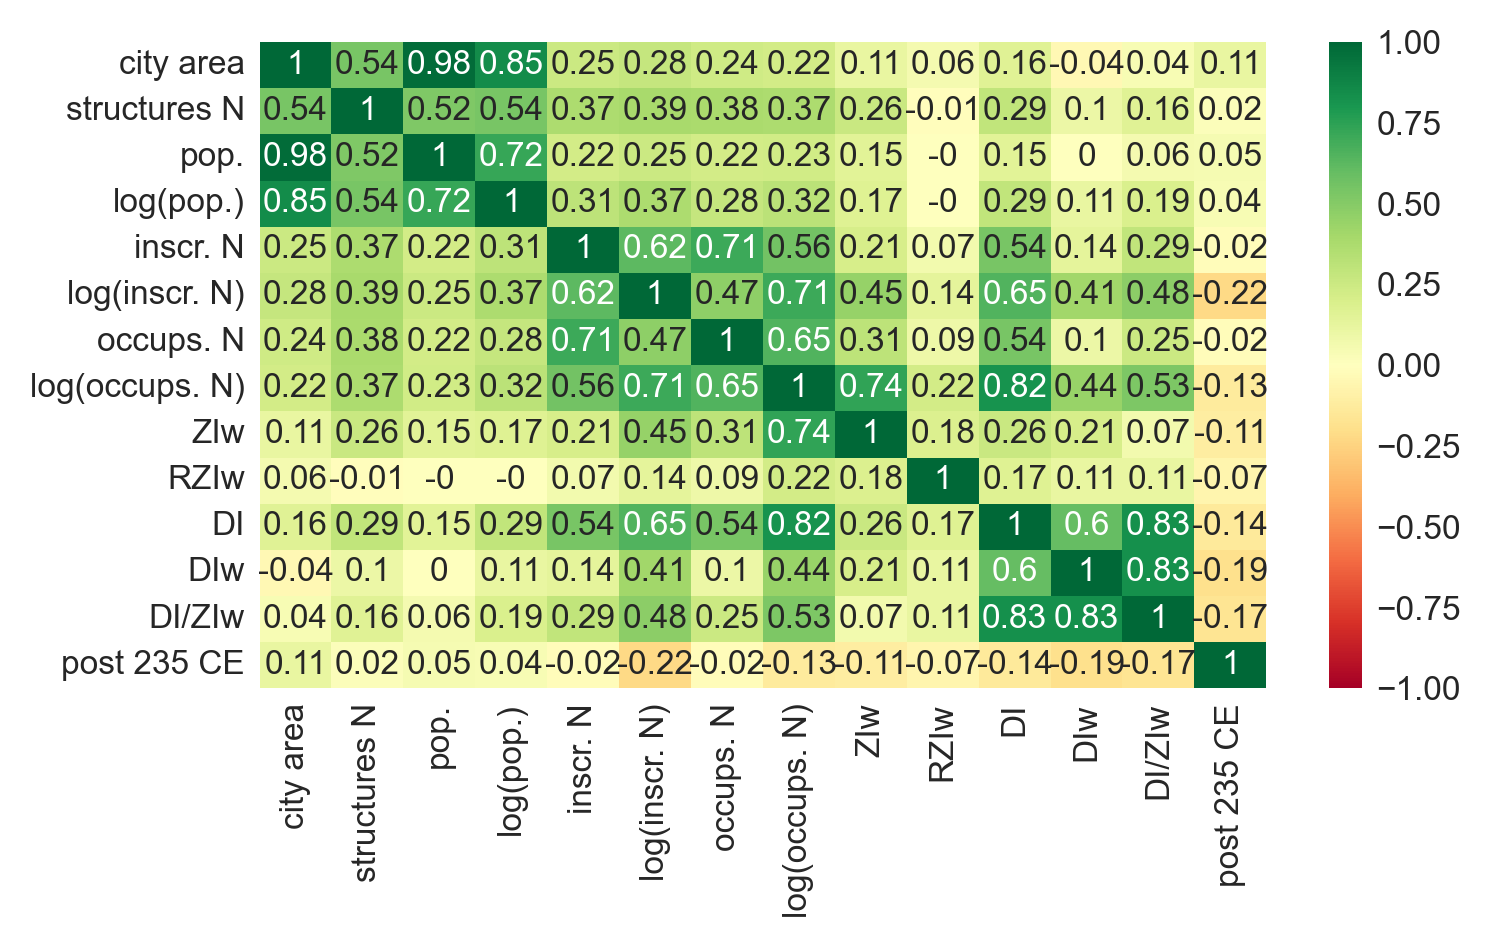

In [362]:
col_labels = ["city area", "structures N", "pop.", "log(pop.)", "inscr. N", "log(inscr. N)", "occups. N", "log(occups. N)", "ZIw", "RZIw", "DI", "DIw", "DI/ZIw", "post 235 CE"]
fig,ax=plt.subplots(figsize=(5.2,3.2), tight_layout=True)
sns.heatmap(corr_matrix, xticklabels=col_labels, yticklabels=col_labels, ax=ax,  cmap="RdYlGn", vmin=-1, vmax=1, annot=True)

In [363]:
save_figure(fig, "DI_ZI_corr_matrix")

A file with the same name ("DI_ZI_corr_matrix.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/DI_ZI_corr_matrix.eps"
A file with the same name ("DI_ZI_corr_matrix.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/DI_ZI_corr_matrix.png"


In [364]:
def get_pvalue_matrix(df):
    df = df.dropna()._get_numeric_data()
    listlist_pvalues = []
    for r in df.columns:
        row_pvalues = []
        for c in df.columns:
            try:
                row_pvalues.append(round(pearsonr(df[r], df[c])[1], 2))
            except:
                row_pvalues.append(None)
        listlist_pvalues.append(row_pvalues)
    return pd.DataFrame(listlist_pvalues, columns=df.columns, index=df.columns)

In [365]:
roman_cities_wo_quant

,Area,num_of_structures,pop_est,pop_est_log,inscr_N,inscr_N_log,occups_N,occups_N_log,ZIw,RZIw,DI,DIw,DI/ZIw,ratio_post235
159,NaN,4,1000.0,6.907755,1.0,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
165,48.0,2,7376.0,8.905987,7.0,1.945910,2.0,0.693147,0.346574,3.521023,2.000000,2.885390,5.770780,0.285714
171,343.0,19,102074.0,11.533453,409.0,6.013715,8.0,2.079442,1.559581,11.241103,1.684211,0.809934,1.079912,0.051345
173,31.0,8,4113.0,8.321908,5.0,1.609438,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.400000
174,NaN,1,1000.0,6.907755,2.0,0.693147,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,131.0,21,28210.0,10.247432,120.0,4.787492,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.108333
1311,67.0,7,11517.0,9.351579,6.0,1.791759,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.166667
1315,36.0,5,5022.0,8.521584,29.0,3.367296,2.0,0.693147,0.693147,2.940019,1.000000,1.442695,1.442695,0.206897
1317,33.0,7,4471.0,8.405367,28.0,3.332205,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


In [366]:
pvalue_matrix = get_pvalue_matrix(roman_cities_wo_quant)
pvalue_matrix

,Area,num_of_structures,pop_est,pop_est_log,inscr_N,inscr_N_log,occups_N,occups_N_log,ZIw,RZIw,DI,DIw,DI/ZIw,ratio_post235
Area,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.33,0.01,0.49,0.44,0.05
num_of_structures,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.78,0.05,0.11
pop_est,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.56,0.04,0.39,0.77,0.08
pop_est_log,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.07,0.00,0.96,0.07,0.01
inscr_N,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.99
inscr_N_log,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08
occups_N,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.23,0.00,0.99
occups_N_log,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19
ZIw,0.05,0.00,0.04,0.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.66,0.40
RZIw,0.33,0.21,0.56,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03


<AxesSubplot:>

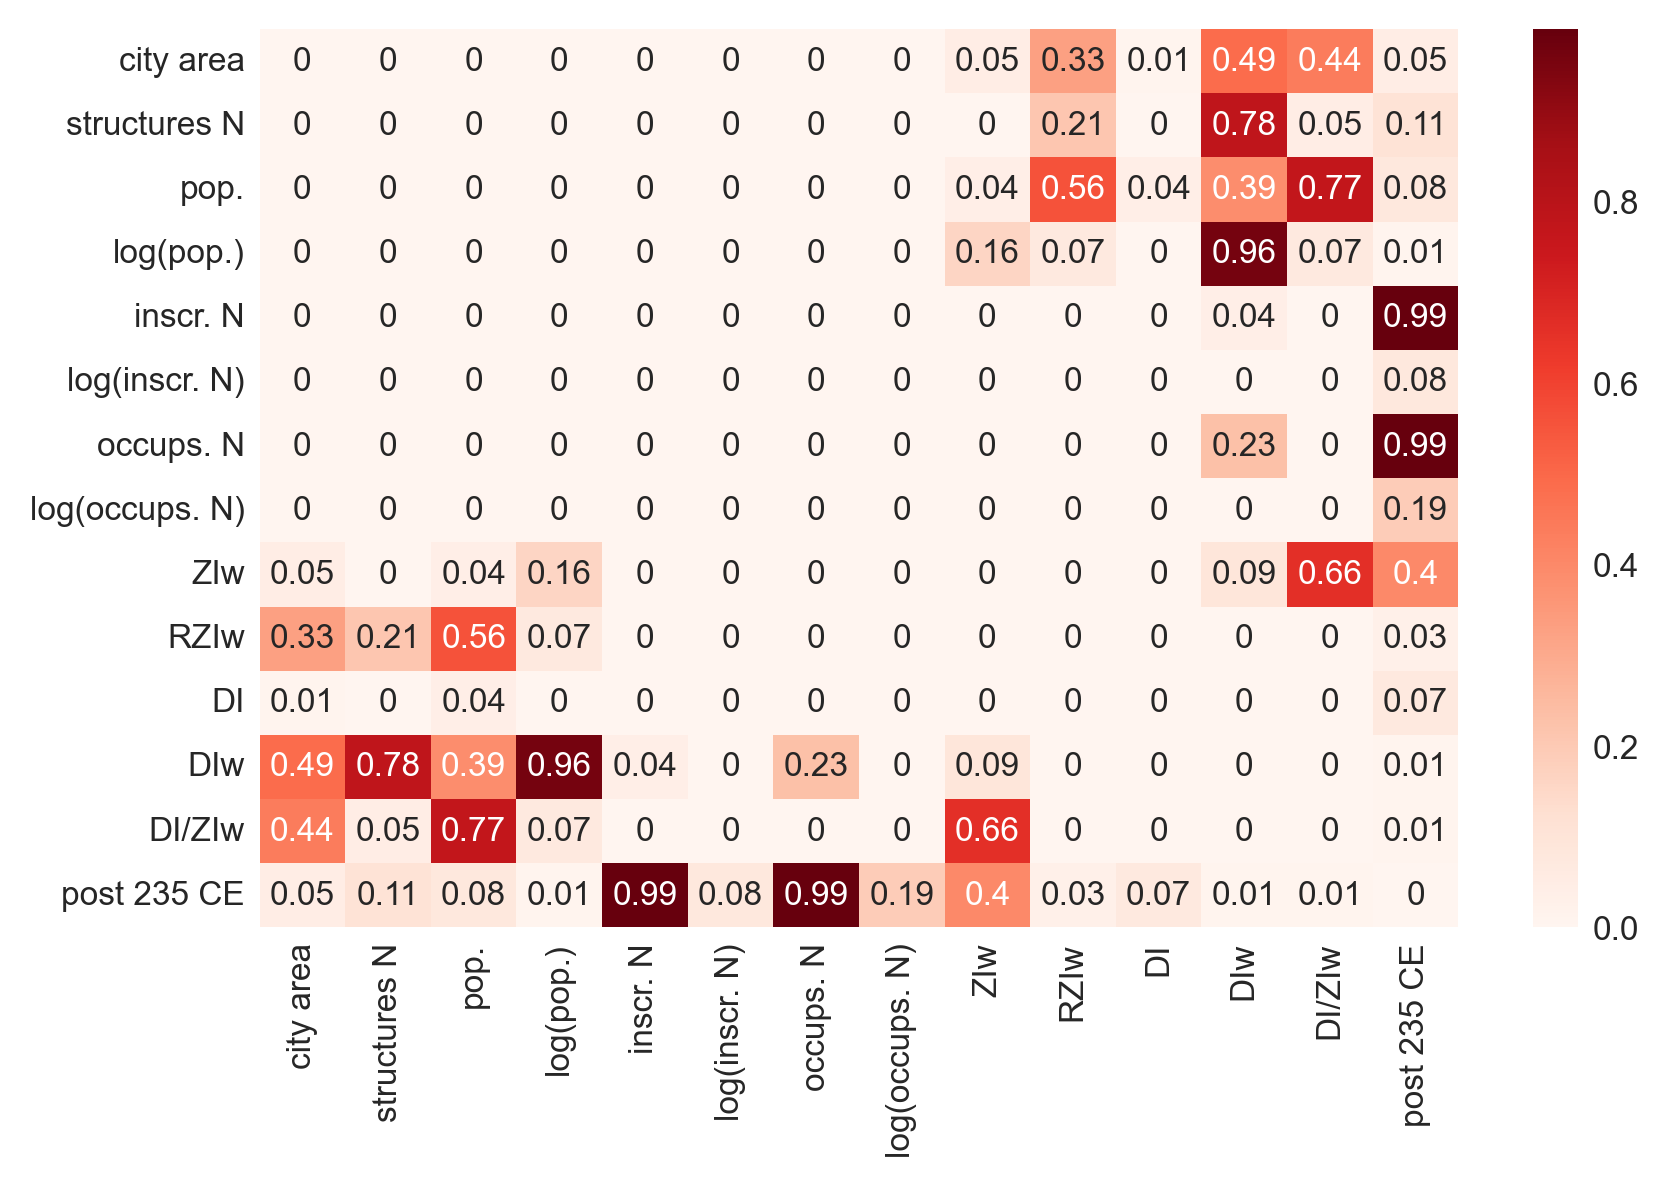

In [367]:
fig,ax=plt.subplots(tight_layout=True)
sns.heatmap(pvalue_matrix, xticklabels=col_labels, yticklabels=col_labels, ax=ax, cmap="Reds", annot=True)

# Specialization and diversity across urban contexts

In [368]:
len(roman_cities_wo)

360

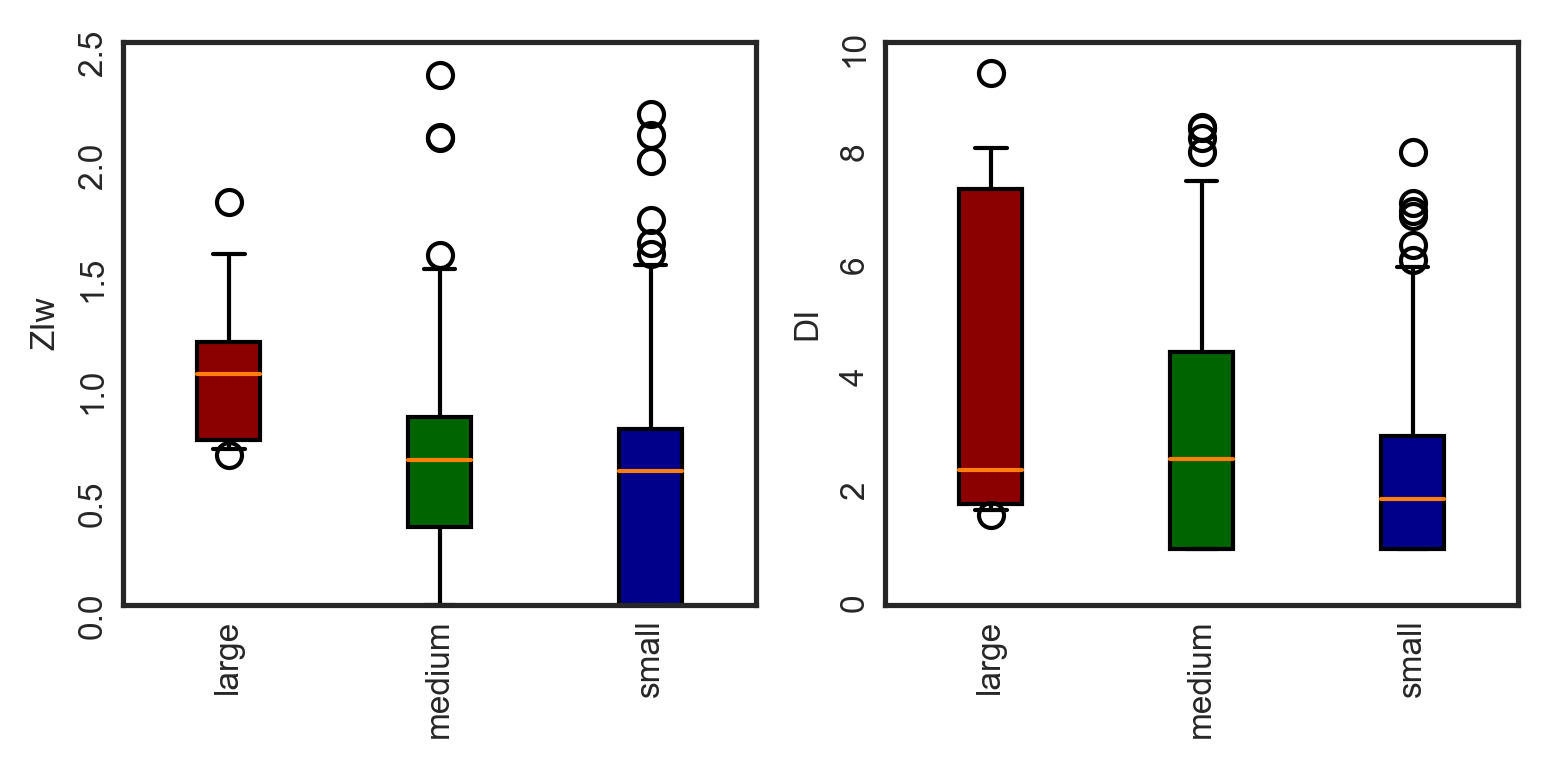

In [379]:
cities_large = roman_cities_wo[roman_cities_wo["pop_est"]>=30000]
cities_medium = roman_cities_wo[(roman_cities_wo["pop_est"] >= 5000) & (roman_cities_wo["pop_est"] < 30000)]
cities_small = roman_cities_wo[roman_cities_wo["pop_est"]<5000]

fig, [ax1, ax2] = plt.subplots(1,2, figsize=[5.2, 2.6], tight_layout=True)

bplot1 = ax1.boxplot([cities_large["ZIw"], cities_medium["ZIw"], cities_small["ZIw"]], whis=[2.5, 97.5], labels=["large", "medium", "small"],
                     patch_artist=True)
#ax1.set_title("A")
ax1.set_ylabel("ZIw")
ax1.tick_params(labelrotation=90)
ax1.set_ylim(0, 2.5)
#ax1.set_ylim(0, 5)

bplot2 = ax2.boxplot([cities_large["DI"], cities_medium["DI"], cities_small["DI"]], whis=[2.5, 97.5], labels=["large", "medium", "small"],
                     patch_artist=True)
#ax1.set_title("A")
ax2.set_ylabel("DI")
ax2.tick_params(labelrotation=90)
ax2.set_ylim(0, 10)

# fill with colors
colors = ["darkred", "darkgreen", "darkblue"]
#for bplot in bplot1:
for bplot in [bplot1, bplot2]:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

In [380]:
cities_large = roman_cities_wo[(roman_cities_wo["pop_est"]>=30000) & (roman_cities_wo["Ancient Toponym"]!="Roma")]
cities_large

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw,city_province,DZI,DI/ZIw
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,1.559581,"[1.3711439588688947, 0.0, 0.0, 0.0, 5.40582770...",5.405828,Miscellaneous Services,11.241103,1.684211,0.809934,Carthago (Africa Proconsularis),1.079912,1.079912
179,Hanson2016_180,Lepcis Magna,Lebda,Africa Proconsularis,Libya,1,35 G2,-30,NaN,Bomgardner 2000; Golvin 1988; Humphrey 1986; L...,...,1.083220,"[0.0, 0.0, 0.0, 0.0, 2.8831081081081082, 1.696...",3.092029,Building,8.373370,2.777778,1.025748,Lepcis Magna (Africa Proconsularis),2.564371,2.564371
398,Hanson2016_399,Londinium,London,Britannia,United Kingdom,2,8 G3,60,NaN,McEvedy 2011; Millett 1990: Table 4.4; Millett...,...,1.194506,"[7.312767780634105, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",7.312768,Metal-Working,13.102721,2.000000,1.116221,Londinium (Britannia),1.674332,1.674332
601,Hanson2016_602,Augustodunum,Autun,Gallia Lugdunensis,France,4 or 5,18 B3,-27,NaN,Benario 1981; Golvin 1988; MacMullen 2000; McE...,...,0.732408,"[0.0, 0.0, 0.0, 0.0, 4.805180180180179, 0.0, 0...",5.153382,Building,5.661568,1.800000,1.638431,Augustodunum (Gallia Lugdunensis),2.457646,2.457646
619,Hanson2016_620,Lugdunum,Lyon,Gallia Lugdunensis,France,1,17 D2,-43,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,0.693147,"[0.0, 0.0, 0.0, 4.13468992248062, 1.3514569256...",4.134690,Transport,11.463795,6.400000,2.308312,Lugdunum (Gallia Lugdunensis),9.233248,9.233248
650,Hanson2016_651,Narbo Martius,Narbonne,Gallia Narbonensis,France,2,25 H2,-45,NaN,Bedon 2001; Bedon et al 1988; Brunt 1971; Corn...,...,1.039721,"[0.0, 0.0, 0.0, 0.0, 5.405827702702703, 0.0, 0...",5.405828,Miscellaneous Services,7.494068,1.600000,1.154156,Narbo Martius (Gallia Narbonensis),1.538875,1.538875
651,Hanson2016_652,Nemausus,Nîmes,Gallia Narbonensis,France,3,15 C2,-52,NaN,Bedon 2001; Bedon et al 1988; Benario 1981; Bo...,...,0.732408,"[0.0, 0.0, 0.0, 22.051679586563306, 0.0, 0.0, ...",22.051680,Transport,24.226246,1.800000,1.638431,Nemausus (Gallia Narbonensis),2.457646,2.457646
757,Hanson2016_758,Capua,S. Maria di Capua Vetere,Italia (I Latium and Campania),Italy,2,44 F3,-550,NaN,Beloch 1880; Beloch 1886; Benario 1981; Bispha...,...,0.665851,"[1.9076785514697665, 2.108201581027668, 3.0413...",3.041340,Finance,11.644200,9.446429,2.467306,Capua (Italia (I Latium and Campania)),14.187008,14.187008
787,Hanson2016_788,Ostia,Ostia,Italia (I Latium and Campania),Italy,2,43 B2,-350,NaN,Beloch 1880; Boatwright 2000; Cornell and Math...,...,1.010435,"[1.2983893814595249, 1.9791280148423005, 0.571...",6.075463,Transport,33.422689,8.110390,1.474279,Ostia (Italia (I Latium and Campania)),8.026631,8.026631


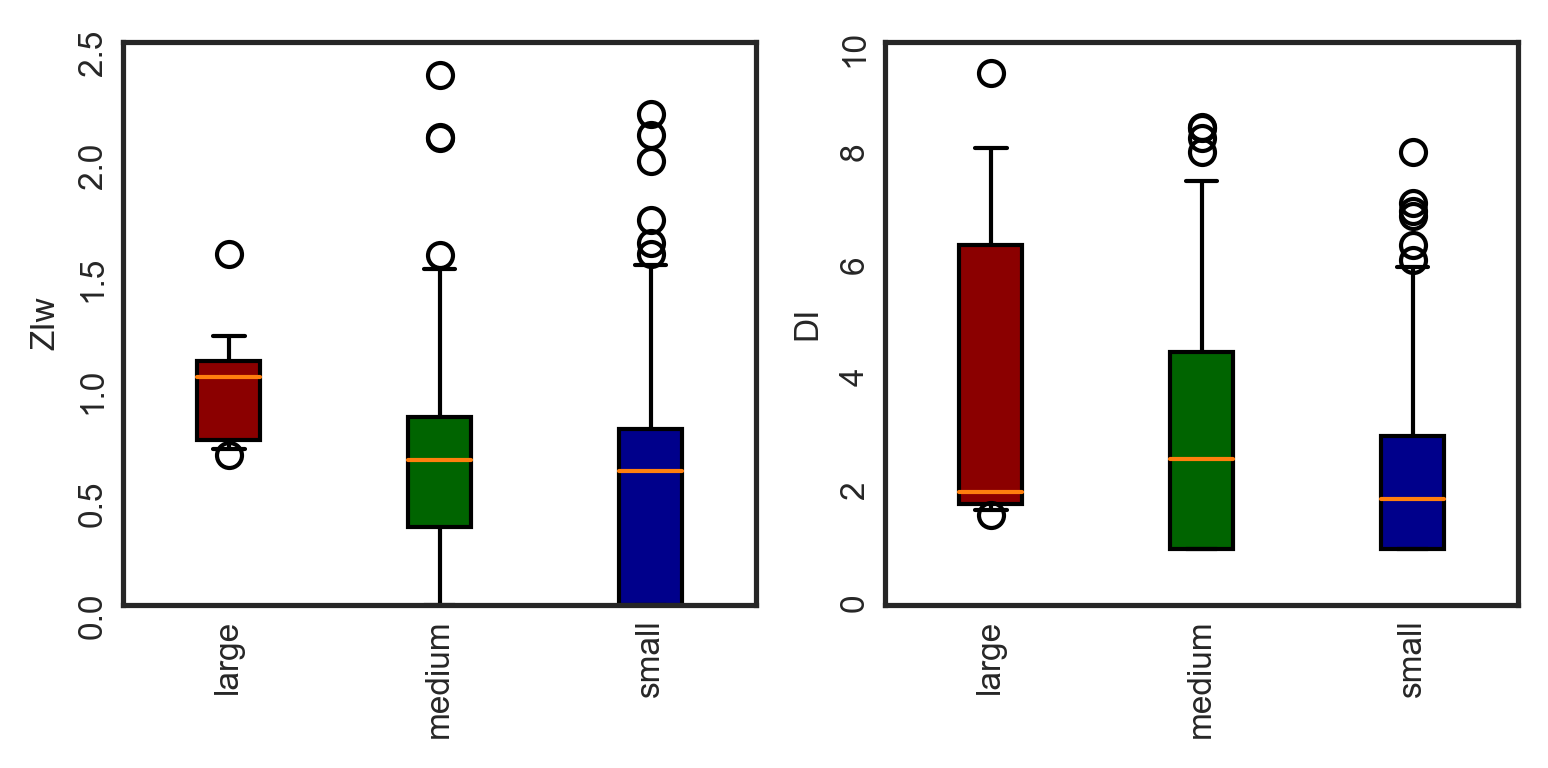

In [381]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=[5.2, 2.6], tight_layout=True)

bplot1 = ax1.boxplot([cities_large["ZIw"], cities_medium["ZIw"], cities_small["ZIw"]], whis=[2.5, 97.5], labels=["large", "medium", "small"],
                     patch_artist=True)
#ax1.set_title("A")
ax1.set_ylabel("ZIw")
ax1.tick_params(labelrotation=90)
ax1.set_ylim(0, 2.5)

bplot2 = ax2.boxplot([cities_large["DI"], cities_medium["DI"], cities_small["DI"]], whis=[2.5, 97.5], labels=["large", "medium", "small"],
                     patch_artist=True)
#ax1.set_title("A")
ax2.set_ylabel("DI")
ax2.tick_params(labelrotation=90)
ax2.set_ylim(0, 10)

# fill with colors
colors = ["darkred", "darkgreen", "darkblue"]
#for bplot in bplot1:
for bplot in [bplot1, bplot2]:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)